# Feature Engineering Challenge Solution

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Challenge%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook we use the following feature engineering strategies:

1. feature selection
2. removing outliers
3. log transformation
4. changing datatypes
5. scaling
6. binning
7. target encoding
8. polynomial features

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

In [2]:
def eval_regression(true, pred, name='Model'):
  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
  scores['MAE'] = [mean_absolute_error(true, pred)]
  scores['R2'] = [r2_score(true, pred)]
  return scores

def eval_classification(true, pred, name='Model'):
  """shows classification_report and confusion matrix
  for the model predictions"""
  
  print(name, '\n')
  print(classification_report(true, pred))
  ConfusionMatrixDisplay.from_predictions(true, pred)
  plt.show()

  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['Precision'] = [precision_score(true, pred)]
  scores['Recall'] = [recall_score(true, pred)]
  scores['F1 Score'] = [f1_score(true, pred)]
  scores['Accuracy'] = [accuracy_score(true, pred)]

  return scores

## Data

Today we will use data about housing sales in Melbourne, Australia

In [3]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQnwAtoM6edkuZ4Xncjx_wnZjN6zcWRtBZdK9wfQwW6AzXCGhOdjvTQrtbsEU5-LxKdOmz5FAtw66tc/pub?gid=1132845715&single=true&output=csv')
df_backup = df.copy()

display(df.head())
print(df.shape)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000,S,Biggin,3/12/2016,2.5,3067,...,1,1.0,202,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019
1,Abbotsford,25 Bloomburg St,2,h,1035000,S,Biggin,04/02/2016,2.5,3067,...,1,0.0,156,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019
2,Abbotsford,5 Charles St,3,h,1465000,SP,Biggin,04/03/2017,2.5,3067,...,2,0.0,134,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019
3,Abbotsford,40 Federation La,3,h,850000,PI,Biggin,04/03/2017,2.5,3067,...,2,1.0,94,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019
4,Abbotsford,55a Park St,4,h,1600000,VB,Nelson,04/06/2016,2.5,3067,...,1,2.0,120,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019


(13580, 21)


## Explore and clean the data
1. Drop the 'Address column', it's too specific.
2. Drop any duplicates
3. Look for missing values.  If you want to drop rows or columns, now is the time.  Wait on imputing until after the split.
4. Check summary statistics to look for outliers.

In [4]:
# drop 'Address' column
df.drop(columns='Address', inplace=True)
df.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,2,h,1480000,S,Biggin,3/12/2016,2.5,3067,2,1,1.0,202,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019
1,Abbotsford,2,h,1035000,S,Biggin,04/02/2016,2.5,3067,2,1,0.0,156,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019
2,Abbotsford,3,h,1465000,SP,Biggin,04/03/2017,2.5,3067,3,2,0.0,134,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019
3,Abbotsford,3,h,850000,PI,Biggin,04/03/2017,2.5,3067,3,2,1.0,94,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019
4,Abbotsford,4,h,1600000,VB,Nelson,04/06/2016,2.5,3067,3,1,2.0,120,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Rooms          13580 non-null  int64  
 2   Type           13580 non-null  object 
 3   Price          13580 non-null  int64  
 4   Method         13580 non-null  object 
 5   SellerG        13580 non-null  object 
 6   Date           13580 non-null  object 
 7   Distance       13580 non-null  float64
 8   Postcode       13580 non-null  int64  
 9   Bedroom2       13580 non-null  int64  
 10  Bathroom       13580 non-null  int64  
 11  Car            13518 non-null  float64
 12  Landsize       13580 non-null  int64  
 13  BuildingArea   7130 non-null   float64
 14  YearBuilt      8205 non-null   float64
 15  CouncilArea    12211 non-null  object 
 16  Lattitude      13580 non-null  float64
 17  Longtitude     13580 non-null  float64
 18  Region

In [6]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
# check for missing values
df.isna().sum()

Suburb              0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [8]:
# drop 'BuildingArea' and 'YearBuilt'

df.drop(columns=['BuildingArea','YearBuilt'], inplace=True)

## Use .describe(include='all') to include categorical columns.

Notice the values in the 'Unique' rows.  Which categorical columns have high cardinality (Many different categories)?

In [9]:
# check summary statistics
df.describe(include='all')

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
count,13580,13580.000000,13580,1.358000e+04,13580,13580,13580,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,12211,13580.000000,13580.000000,13580,13580.000000
unique,314,NaN,3,NaN,5,268,58,NaN,NaN,NaN,NaN,NaN,NaN,33,NaN,NaN,8,NaN
top,Reservoir,NaN,h,NaN,S,Nelson,27/05/2017,NaN,NaN,NaN,NaN,NaN,NaN,Moreland,NaN,NaN,Southern Metropolitan,NaN
freq,359,NaN,9449,NaN,9022,1565,473,NaN,NaN,NaN,NaN,NaN,NaN,1163,NaN,NaN,4695,NaN
mean,NaN,2.937997,NaN,1.075684e+06,NaN,NaN,NaN,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,NaN,-37.809203,144.995216,NaN,7454.417378
std,NaN,0.955748,NaN,6.393107e+05,NaN,NaN,NaN,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,NaN,0.079260,0.103916,NaN,4378.581772
min,NaN,1.000000,NaN,8.500000e+04,NaN,NaN,NaN,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,NaN,-38.182550,144.431810,NaN,249.000000
25%,NaN,2.000000,NaN,6.500000e+05,NaN,NaN,NaN,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,NaN,-37.856822,144.929600,NaN,4380.000000
50%,NaN,3.000000,NaN,9.030000e+05,NaN,NaN,NaN,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,NaN,-37.802355,145.000100,NaN,6555.000000
75%,NaN,3.000000,NaN,1.330000e+06,NaN,NaN,NaN,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,NaN,-37.756400,145.058305,NaN,10331.000000


In [10]:
df['Price'].describe()

count    1.358000e+04
mean     1.075684e+06
std      6.393107e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.030000e+05
75%      1.330000e+06
max      9.000000e+06
Name: Price, dtype: float64


 Rooms 



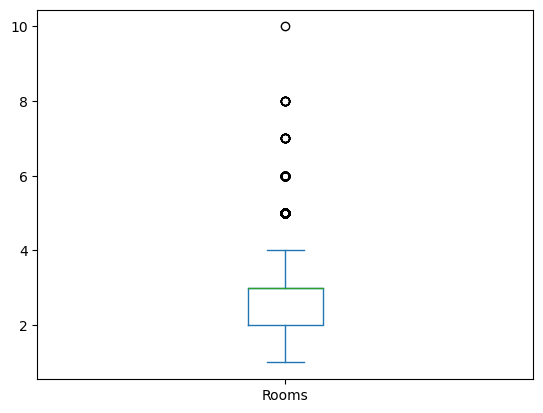


 Price 



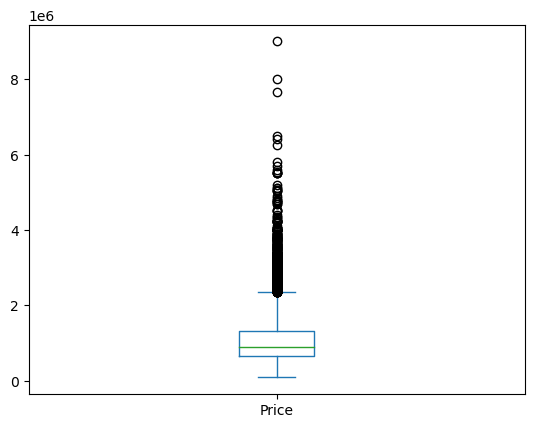


 Distance 



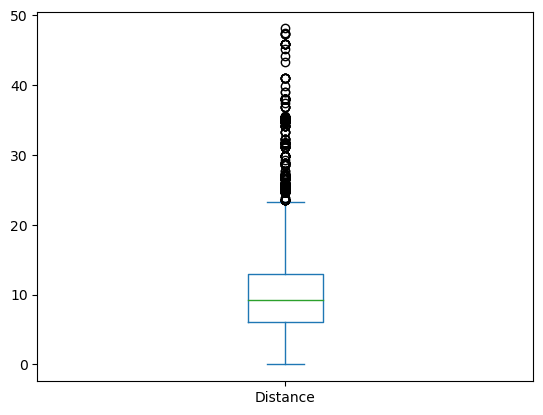


 Postcode 



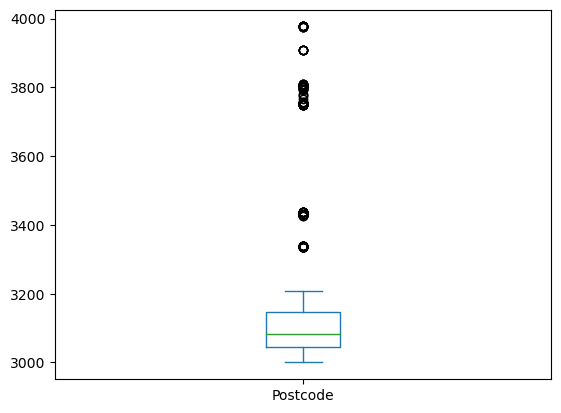


 Bedroom2 



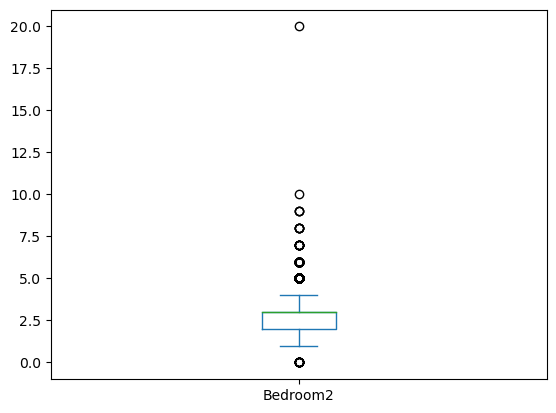


 Bathroom 



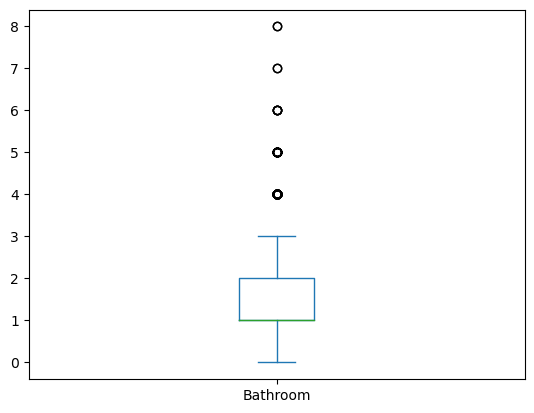


 Car 



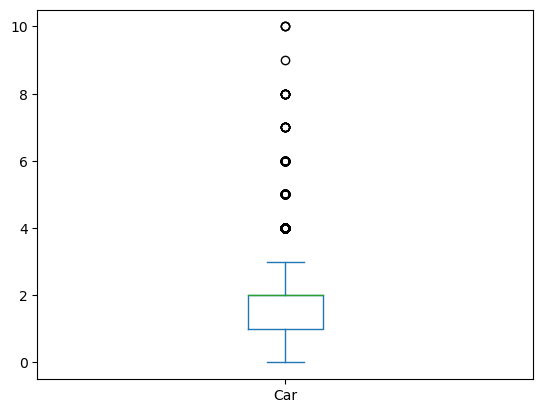


 Landsize 



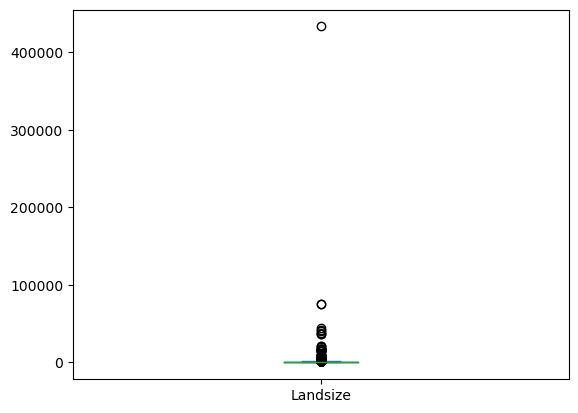


 Lattitude 



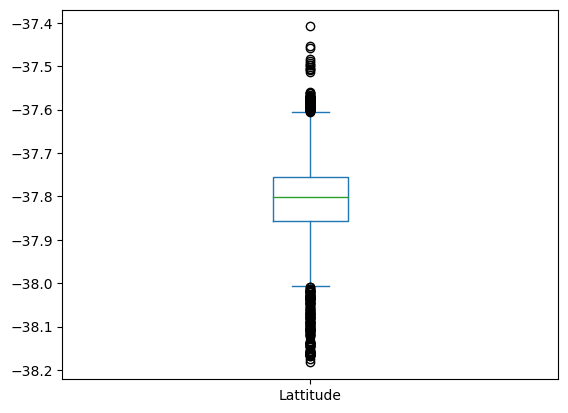


 Longtitude 



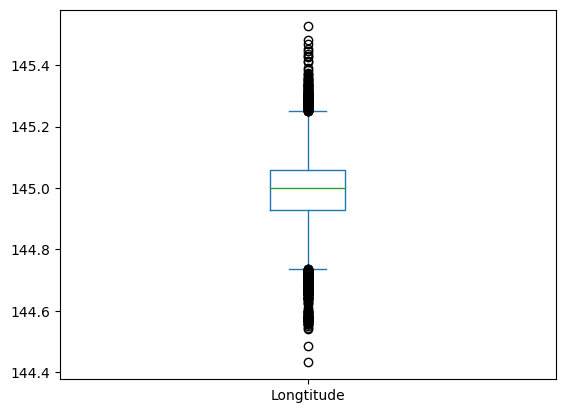


 Propertycount 



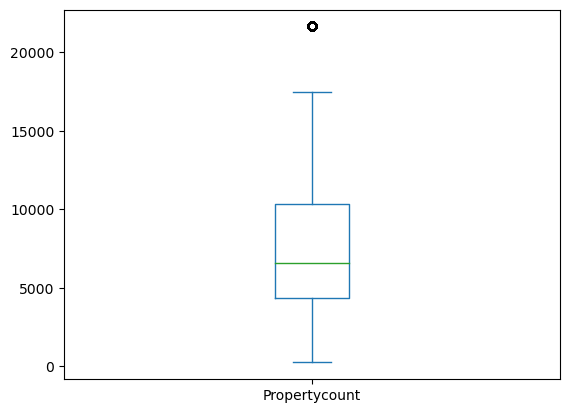

In [11]:
# explore numeric distributions
for col in df.select_dtypes('number'):
  print('\n', col, '\n')
  df[col].plot(kind='box')
  plt.show()

# Feature Engineering

What would you do to improve this dataset?

### Some Ideas:
1. Remove outliers
2. Change the distribution with np.log, np.sqrt, np.cbrt
3. Bin features or target with .replace or .apply
4. Combine features
5. Extract hour, day, or month from datetime
6. Encode data: one-hot encoding, ordinal encoding, target encoding
7. Parse strings
8. Try different imputation strategies

# Categorical Feature Engineering

In [12]:
for col in df.select_dtypes('object'):
  print(col, df[col].nunique())

Suburb 314
Type 3
Method 5
SellerG 268
Date 58
CouncilArea 33
Regionname 8


In [13]:
# drop 'SellerG' and 'Suburb' because they have high cardinality

df.drop(columns=['SellerG','Suburb'], inplace=True)

# Engineer datetime columns

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].dtype

dtype('<M8[ns]')

In [15]:
df['Month'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day_name()
df['Year'] = df['Date'].dt.year

In [16]:
df.drop(columns='Date', inplace=True)

# Numeric Feature Engineering

### Filter to remove outliers

In [17]:
df['Landsize'].describe()

count     13580.000000
mean        558.416127
std        3990.669241
min           0.000000
25%         177.000000
50%         440.000000
75%         651.000000
max      433014.000000
Name: Landsize, dtype: float64

In [18]:
# exclude houses with more than 100000m^2 of land
df = df[df['Landsize'] < 100000]
df['Landsize'].describe()

count    13579.000000
mean       526.568746
std       1466.972242
min          0.000000
25%        177.000000
50%        440.000000
75%        651.000000
max      76000.000000
Name: Landsize, dtype: float64

## Transform to normalize feature

<AxesSubplot: >

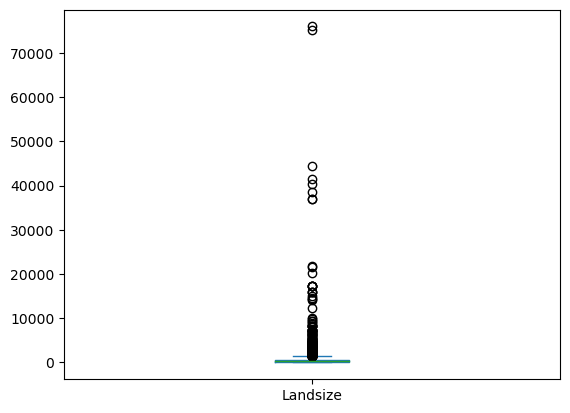

In [19]:
df['Landsize'].plot(kind='box')

In [20]:
# log transform 'distance_travelled(kms)'
# df['LogLandsize'] = np.log(df['Landsize'], where=df['Landsize'] > 0)
# df['LogLandsize'].plot(kind='box')

In [21]:
df.drop(columns='Landsize', inplace=True)

### Converting 'Postcode' to object type since it's categorical

In [22]:
df['Postcode'] = df['Postcode'].astype('object')

## Validation Split

In [23]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [24]:
X_train.head()

,Rooms,Type,Method,Distance,Postcode,Bedroom2,Bathroom,Car,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Month,Day,Year
11958,4,h,S,20.6,3064,4,2,2.0,Hume,-37.58505,144.93592,Northern Metropolitan,15510,July,Saturday,2017
10119,3,t,S,9.7,3104,3,2,1.0,Boroondara,-37.79294,145.08583,Southern Metropolitan,7809,May,Saturday,2017
12481,3,h,S,14.3,3109,3,1,2.0,NaN,-37.78649,145.16774,Eastern Metropolitan,10999,September,Saturday,2017
5775,3,h,S,6.1,3182,3,2,3.0,Port Phillip,-37.86450,144.98050,Southern Metropolitan,13240,April,Monday,2017
3219,1,u,PI,4.6,3122,1,1,1.0,Boroondara,-37.82220,145.03290,Southern Metropolitan,11308,August,Sunday,2016


# Engineer the Target

### Change from regression to classification problem

In [25]:
mean_price = y_train.mean()
y_train = y_train.apply(lambda x: 1 if x > mean_price else 0)
y_test = y_test.apply(lambda x: 1 if x > mean_price else 0)

# Modeling: Base Model

In [26]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')


num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(missing_imputer, ohe)

processor = make_column_transformer((num_pipe, num_cols),
                                    (cat_pipe, cat_cols))

print(processor.fit_transform(X_train).shape)

(10184, 272)


In [27]:
# Instantiate and fit model

scores = pd.DataFrame()

logreg2 = LogisticRegression()
log_pipe2 = make_pipeline(processor, logreg2)
log_pipe2.fit(X_train, y_train)

train_pred = log_pipe2.predict(X_train)
test_pred = log_pipe2.predict(X_test)

Train 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6302
           1       0.86      0.86      0.86      3882

    accuracy                           0.89     10184
   macro avg       0.88      0.88      0.88     10184
weighted avg       0.89      0.89      0.89     10184



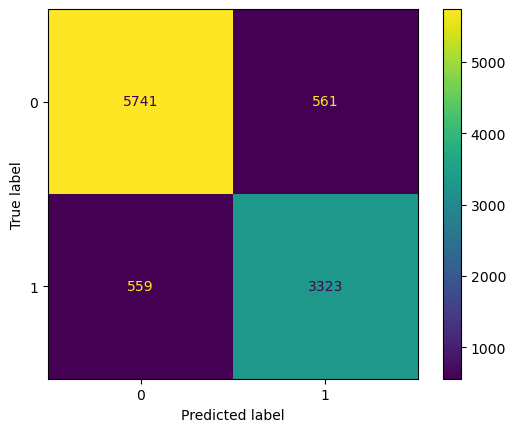

Test 

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2036
           1       0.85      0.85      0.85      1359

    accuracy                           0.88      3395
   macro avg       0.88      0.88      0.88      3395
weighted avg       0.88      0.88      0.88      3395



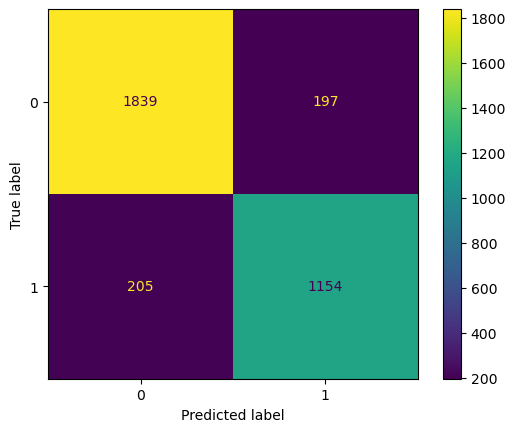

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Train,0.855561,0.856002,0.855782,0.890024
0,Test,0.854182,0.849154,0.851661,0.881591


In [28]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='Train')

test_scores = eval_classification(y_test, test_pred, name='Test')

log_scores = pd.concat([train_scores, test_scores])
log_scores

# Modeling: PolynomialFeatures

## Test PolynomialFeatures to see how it changes data

We are working here with the entire dataframe to illustrate how the model combines numeric features.  We won't apply the transformers until later.

In [29]:
# Create scaler and polynomial features
poly = PolynomialFeatures(degree=3)
scaler = StandardScaler()

# Scale the data
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Lattitude','Longtitude']]), 
                            columns=df[['Lattitude','Longtitude']].columns)

poly_train = poly.fit_transform(df_scaled)
poly_train = pd.DataFrame(poly_train, columns=poly.get_feature_names_out())

poly_train.head()

,1,Lattitude,Longtitude,Lattitude^2,Lattitude Longtitude,Longtitude^2,Lattitude^3,Lattitude^2 Longtitude,Lattitude Longtitude^2,Longtitude^3
0,1.0,0.121166,0.030630,0.014681,0.003711,0.000938,1.778866e-03,4.496839e-04,1.136767e-04,2.873662e-05
1,1.0,0.016447,-0.017486,0.000271,-0.000288,0.000306,4.449071e-06,-4.730134e-06,5.028952e-06,-5.346648e-06
2,1.0,-0.001216,-0.007863,0.000001,0.000010,0.000062,-1.799480e-09,-1.163275e-08,-7.520007e-08,-4.861316e-07
3,1.0,0.155231,0.016195,0.024097,0.002514,0.000262,3.740570e-03,3.902487e-04,4.071412e-05,4.247650e-06
4,1.0,0.025279,-0.010750,0.000639,-0.000272,0.000116,1.615367e-05,-6.869393e-06,2.921228e-06,-1.242260e-06


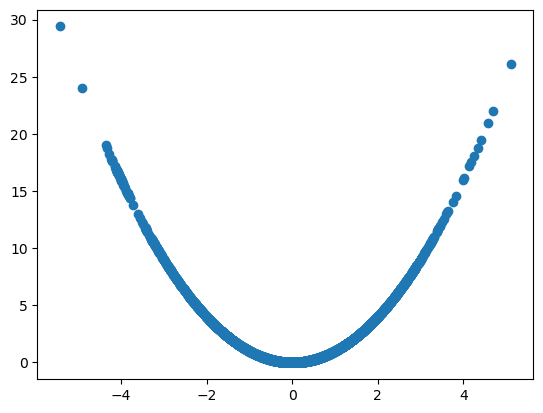

In [30]:
# Plot distance vs distance^2
plt.scatter(data=poly_train, x='Longtitude', y='Longtitude^2')

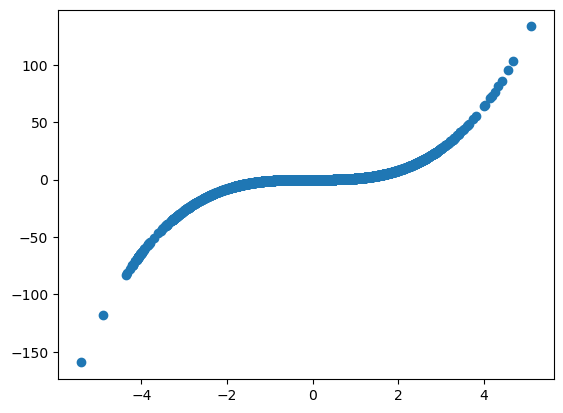

In [31]:
plt.scatter(data=poly_train, x='Longtitude', y='Longtitude^3')

## Use PolynomialFeatures in a model pipeline

In [32]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
poly = PolynomialFeatures(degree=2)

median_imputer = SimpleImputer(strategy='median')
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

num_pipe = make_pipeline(median_imputer, scaler, poly)
cat_pipe = make_pipeline(missing_imputer, ohe)

processor = make_column_transformer((num_pipe, num_cols), (cat_pipe, cat_cols))
print(processor.fit_transform(X_train, y_train).shape)

(10184, 318)


In [33]:
# Instantiate and fit model with Polynomial Features

scores = pd.DataFrame()

logreg2 = LogisticRegression()
log_pipe2 = make_pipeline(processor, logreg2)
log_pipe2.fit(X_train, y_train)

train_pred = log_pipe2.predict(X_train)
test_pred = log_pipe2.predict(X_test)

poly_Train 

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      6302
           1       0.86      0.85      0.86      3882

    accuracy                           0.89     10184
   macro avg       0.89      0.89      0.89     10184
weighted avg       0.89      0.89      0.89     10184



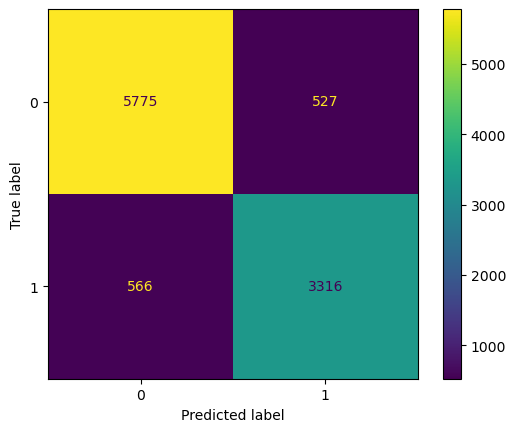

poly_Test 

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2036
           1       0.86      0.85      0.86      1359

    accuracy                           0.89      3395
   macro avg       0.88      0.88      0.88      3395
weighted avg       0.89      0.89      0.89      3395



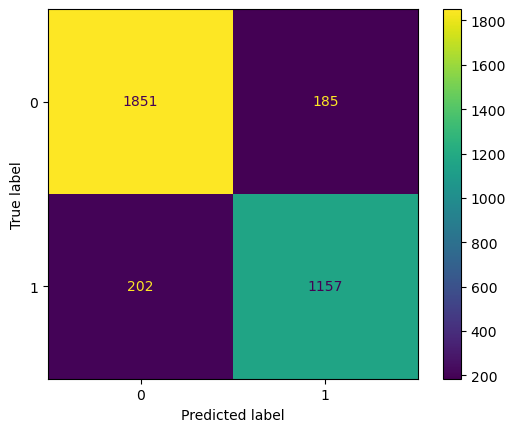

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Train,0.855561,0.856002,0.855782,0.890024
0,Test,0.854182,0.849154,0.851661,0.881591
0,poly_Train,0.862868,0.854199,0.858511,0.892675
0,poly_Test,0.862146,0.851361,0.856720,0.886009


In [34]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='poly_Train')

test_scores = eval_classification(y_test, test_pred, name='poly_Test')

scores = pd.concat([log_scores, train_scores, test_scores])
scores

## What if we increase the degree?

# Your Turn:  See if you can beat my accuracy

You might try:
1. Engineering the Date column
2. PolynomialFeatures on all features after encoding
3. Removing more duplicates or transforming features with np.log or np.sqrt
4. Binning other features
5. Different categorical encoding approaches